In [36]:
from datasets import load_dataset
from torchvision import transforms
import json
"""
Parameters:

- datset_name: also include train/test split

- hf_dataset: the dataset identifier in huggingface;

- optimized_dir: directory to save optimized_dataset;

- image_key: "webp", "jpg" or "png";

- id_key: the id attribute in dataset card, default is "__key__"

- label_key: the text/caption attribute in dataset card, default is "cls" 

- threshold(inclusive): the maximum distance for search results, in hamming distance, how many bits in the hash string is different.

- perceptual hash or average hash

- k: the number of results to show

NOTE: need to provicde classes as a list if labels are numerical ELSE LEFT THE CLASSES LIST EMPTY
"""

dataset_name = "cars"
split = "test"
# hf_dataset = load_dataset("clip-benchmark/wds_vtab-food101", split="test", streaming=False)

threshold = 4
method = "perceptual" 

k = 5

"""LEFT CLASSES LIST EMPTY IF NO NEED TO PROVIDE IT"""
classes = json.load(open(f"data/classes_{dataset_name}.json", "r"))
print(len(classes))

196


# Load dataset from Huggingface

Optimize hf dataset for fast search and retrival.

In [37]:
if dataset_name == "cifar100":
    hf_dataset = load_dataset("clip-benchmark/wds_vtab-cifar100", split=split, streaming=False)
elif dataset_name == "caltech101":
    hf_dataset = load_dataset("clip-benchmark/wds_vtab-caltech101", split=split, streaming=False)
elif dataset_name == "food101":
    hf_dataset = load_dataset("clip-benchmark/wds_food101", split=split, streaming=False)
elif dataset_name == "cars":
    hf_dataset = load_dataset("clip-benchmark/wds_cars", split=split, streaming=False)
elif dataset_name == "country211":
    hf_dataset = load_dataset("clip-benchmark/wds_country211", split=split, streaming=False)
elif dataset_name == "sun397":
    hf_dataset = load_dataset("clip-benchmark/wds_sun397", split=split, streaming=False)
elif dataset_name == "fer2013":
    hf_dataset = load_dataset("clip-benchmark/wds_fer2013", split=split, streaming=False)
elif dataset_name == "aircraft":
    hf_dataset = load_dataset("clip-benchmark/wds_fgvc_aircraft", split=split, streaming=False)
elif dataset_name == "imagenetv2":
    hf_dataset = load_dataset("clip-benchmark/wds_imagenetv2", split=split, streaming=False)
elif dataset_name == "imagenet-o":
    hf_dataset = load_dataset("clip-benchmark/wds_imagenet-o", split=split, streaming=False)
elif dataset_name == "pets":
    hf_dataset = load_dataset("clip-benchmark/wds_vtab-pets", split=split, streaming=False)
elif dataset_name == "imagenet-a":
    hf_dataset = load_dataset("clip-benchmark/wds_imagenet-a", split=split, streaming=False)
elif dataset_name == "imagenet-r":
    hf_dataset = load_dataset("clip-benchmark/wds_imagenet-r", split=split, streaming=False)

if "webp" in hf_dataset[0] and hf_dataset[0]["webp"] is not None:
    image_key = "webp"
elif hf_dataset[0]["jpg"] is not None:
    image_key = "jpg"
    
dataset_name += "-" + split
print(dataset_name)

cars-test


In [38]:
import os
import json
from pathlib import Path
from PIL import Image
# from lightning.data import StreamingDataset, StreamingDataLoader
# from lightning.data.streaming.serializers import JPEGSerializer

def optimize_hf_to_lightning(hf_dataset, output_dir, image_key="webp", id_key="__key__", label_key="cls"):
    """
    Iterates over the Hugging Face dataset and saves each sample to disk in a format
    that Lightning's StreamingDataset can read. An index file (index.json) is created.
    
    Each sample is stored as:
      - An image file in JPEG format
      - A metadata entry in the index that records the file path and label
    
    Parameters:
      hf_dataset: The Hugging Face dataset (can be streaming or in-memory)
      output_dir: Directory where the optimized dataset will be stored.
      image_key: Field name in the dataset containing image data.
      id_key: Field name to use as a unique identifier.
      label_key: Field name containing label or class information.
    Returns:
      The output directory path (which contains the data and index).
    """

    os.makedirs(output_dir, exist_ok=True)
    index = {}
    # serializer = JPEGSerializer()  # Can be used to serialize images if desired.
    
    # Iterate over the dataset and write each sample.
    for sample in hf_dataset:
        uid = sample[id_key]
        # Define a file path for the image.
        image_filename = f"{uid}.jpeg"
        image_path = os.path.join(output_dir, image_filename)
        
        # Get the image. Depending on your dataset, it might already be a PIL Image.
        image = sample[image_key]
        if not isinstance(image, Image.Image):
            # If image is not a PIL image, try converting it.
            image = Image.fromarray(image)
            
        if image.mode != "RGB":
            image = image.convert("RGB")
        # Save the image in JPEG format.
        image.save(image_path, format="JPEG")
        
        # Record metadata in the index.
        index[uid] = {
            "image_path": image_filename,  # Store relative path
            "label": sample[label_key],
        }
    
    # Write out the index file.
    index_path = os.path.join(output_dir, "index.json")
    with open(index_path, "w") as f:
        json.dump(index, f)
    
    return output_dir

In [39]:
import os
import io
import json
from PIL import Image
import imagehash
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class HFDataset(Dataset):

    def __init__(self, root_dir, index_file, lookup=None, transform=None):
        self.root_dir = root_dir
        with open(os.path.join(root_dir, index_file), "r") as f:
            self.index_data = json.load(f)
        self.lookup = lookup
        self.samples = list(self.index_data.items())
        self.uid_to_sample = dict(self.samples)
        self.transform = transform 


    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, index):
        uid, sample = self.samples[index]
        image_path = os.path.join(self.root_dir, sample["image_path"])
        pil_image = Image.open(image_path).convert("RGB")
        text = self.lookup[sample["label"]] if self.lookup else sample["label"]

        ahash = str(imagehash.average_hash(pil_image))
        phash = str(imagehash.phash(pil_image))

        return index, text, ahash, phash, uid

    def get_by_id(self, uid):
        """
        Retrieve a raw PIL image and metadata by its unique identifier.
        """
        # if uid not in self.uid_to_sample:
        #     raise KeyError(f"UID: {uid} not found in dataset.")
        sample = self.uid_to_sample[uid]
        image_path = os.path.join(self.root_dir, sample["image_path"])
        pil_image = Image.open(image_path).convert("RGB")
        text = self.lookup[sample["label"]] if self.lookup else sample["label"]
        ahash = imagehash.average_hash(pil_image)
        phash = str(imagehash.phash(pil_image))

        return pil_image, text, ahash, phash

('Suzuki Aerio Sedan 2007', 'Ferrari 458 Italia Convertible 2012', 'Jeep Patriot SUV 2012', 'Toyota Camry Sedan 2012', 'Tesla Model S Sedan 2012', 'Chrysler Town and Country Minivan 2012', 'GMC Terrain SUV 2012', 'Mercedes-Benz S-Class Sedan 2012', 'BMW X5 SUV 2007', 'Chevrolet HHR SS 2010', 'Buick Verano Sedan 2012', 'Ford Freestar Minivan 2007', 'Ford E-Series Wagon Van 2012', 'Hyundai Elantra Sedan 2007', 'Dodge Caliber Wagon 2012', 'Cadillac CTS-V Sedan 2012', 'Land Rover Range Rover SUV 2012', 'BMW X6 SUV 2012', 'Audi S5 Coupe 2012', 'BMW X5 SUV 2007', 'Lamborghini Aventador Coupe 2012', 'Acura TL Type-S 2008', 'Chrysler PT Cruiser Convertible 2008', 'Ford Mustang Convertible 2007', 'Mercedes-Benz S-Class Sedan 2012', 'Volkswagen Golf Hatchback 1991', 'Nissan Juke Hatchback 2012', 'Volvo XC90 SUV 2007', 'Dodge Dakota Club Cab 2007', 'Acura TSX Sedan 2012', 'Mercedes-Benz E-Class Sedan 2012', 'Jeep Grand Cherokee SUV 2012') ('ffffc7838181f3ff', '47838180cfffffff', 'ffffcf9000202000

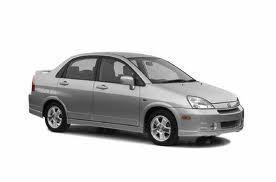

In [40]:
optimized_dir = f"data/optimized_dataset/{dataset_name}"

if not os.path.exists(os.path.join(optimized_dir, "index.json")):
    optimize_hf_to_lightning(hf_dataset, optimized_dir, image_key=image_key)

dataset = HFDataset(
        index_file = "index.json",
        root_dir=optimized_dir,
        lookup=classes if classes else None,
        # transform = transform
        )

dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
for _, texts, ahashes, phashes, uids in dataloader:
    print(texts, ahashes, phashes, uids)
    break
sample_uid = dataset.samples[0][0]
pil_image, text, ahash, phash = dataset.get_by_id(sample_uid)
pil_image.show()

# Load the laion400m dataset

In [41]:
"""load the laion400m dataset for image retrival"""
import os
from lightning_cloud.utils.data_connection import add_s3_connection
from lightning.data import StreamingDataset, StreamingDataLoader
from lightning.data.streaming.serializers import JPEGSerializer
import torchvision.transforms.v2 as T
from tqdm import tqdm
import imagehash
import torchvision.transforms as T
import matplotlib.pyplot as plt 
import numpy as np
import torch
import json
import concurrent
from PIL import Image
import io

# 1. Add the prepared dataset to your teamspace
add_s3_connection("laoin-400m")

# 2. Create the streaming dataset
class LAOINStreamingDataset(StreamingDataset):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.serializer = JPEGSerializer()

    def __getitem__(self, index):
        id, image, text, _, _, _ = super().__getitem__(index)
        
        return Image.open(io.BytesIO(image)), text, str(id)

laion = LAOINStreamingDataset(input_dir="/teamspace/s3_connections/laoin-400m")

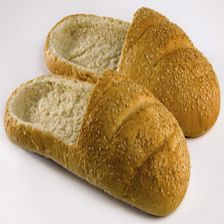

In [42]:
laion[69815173][0]

# FILTERING


## WITH AVERAGE HASH

In [43]:
# """
# EXTRA CELL FOR RANDOM TEST
# plot original image and overlap images
# one row per plot
# """
# from PIL import Image, UnidentifiedImageError
# from io import BytesIO
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import pandas as pd
# import textwrap
# import json
# import glob

# def resize_image(image, target_size=(256, 256)):
#     return image.resize(target_size, Image.Resampling.LANCZOS)

# def show_match_results_single_wahash(dataset, results, output_dir, k=5):

#     cols = k + 2
#     for uid, match_indices in tqdm(results.items(), desc=f"plotting duplicate images for {dataset_name}"):
#         fig, axes = plt.subplots(1, cols, figsize=(cols * 3, 3))
#         axes[0].text(0.5, 0.5, uid, fontsize=24, ha='center', va='center')
#         axes[0].axis("off")

#         original_image, original_text, ahash, phash= dataset.get_by_id(uid)
#         original_image_resized = resize_image(original_image)
#         axes[1].imshow(original_image_resized)
#         wrapped_caption = "\n".join(textwrap.wrap(original_text, width=24))
#         axes[1].set_title(wrapped_caption)
#         axes[1].axis('off')

#         correct = 0
#         for j in range (k):
#             ax = axes[j + 2]
#             if j >= len(match_indices):
#                 ax.imshow(np.ones((1, 1, 3)))
#             else:
#                 idx = match_indices[j]
#                 match_image, match_text, _ = laion[idx]
#                 laion_phash = imagehash.phash(match_image)
#                 p_dist = abs(imagehash.hex_to_hash(phash) - laion_phash)
#                 laion_ahash = imagehash.average_hash(match_image)
#                 a_dist = abs(ahash - laion_ahash)
#                 if a_dist <= 4:
#                     ax.imshow(match_image)
#                     warapped_lines = "a_dist: " + str(a_dist) + ", p_dist: " + str(a_dist)
#                     wrapped_caption_match = "\n".join(wrapped_lines[:2])
#                     ax.set_title(wrapped_caption_match, fontsize=8)
#                     correct += 1
#                 else:
#                     ax.imshow(np.ones((1, 1, 3)))
#             ax.axis('off')
#         if correct > 0:
#             plt.tight_layout()
#             plt.savefig(os.path.join(output_dir, f"{uid}.png"))
#         plt.close(fig)

# # find-overlaps-in-laion-400m
# input_dir = f"/teamspace/studios/this_studio/data/intermediate/{dataset_name}/match_indices_{threshold}"
# input_file = os.path.join(input_dir, "combined_results.json")
# output_dir = f"/teamspace/studios/this_studio/data/intermediate/{dataset_name}/plots-ahash"
# os.makedirs(output_dir, exist_ok=True)

# with open(input_file, "r") as f:
#     results = json.load(f)
#     show_match_results_single_wahash(dataset, results, output_dir, k)
# print("Plotted all images: ", output_dir)

# correct = glob.glob(f"/teamspace/studios/this_studio/data/intermediate/{dataset_name}/plots-ahash/*.png")

# with open(f"/teamspace/studios/this_studio/data/final/{dataset_name}/final_results.json", "r") as f:
#     final_results = json.load(f)

# print("final_results(hand picked):", len(final_results))
# print("results filtered with average hash:", len(correct))
# print("error rate: ", round(abs(len(final_results) - len(correct))/ len(correct), 4) * 100, "%")

## WITH CLIP

In [45]:
"""
EXTRA CELL FOR RANDOM TEST
plot original image and overlap images
one row per plot
"""
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import textwrap
import json
import clip
import torch
import numpy as np
import glob

def resize_image(image, target_size=(256, 256)):
    return image.resize(target_size, Image.Resampling.LANCZOS)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def show_match_results_single_clip(dataset, results, output_dir, k=5):
    cols = k + 2
    for uid, match_indices in tqdm(results.items(), desc=f"plotting duplicate images for {dataset_name}"):
        fig, axes = plt.subplots(1, cols, figsize=(cols * 3, 3))
        axes[0].text(0.5, 0.5, uid, fontsize=24, ha='center', va='center')
        axes[0].axis("off")

        original_image, original_text, _, _= dataset.get_by_id(uid)
        original_image_resized = resize_image(original_image)
        axes[1].imshow(original_image_resized)
        wrapped_caption = "\n".join(textwrap.wrap(original_text, width=24))
        axes[1].set_title(wrapped_caption)
        axes[1].axis('off')
        orig_input = preprocess(original_image).unsqueeze(0).to(device)
        with torch.no_grad():
            orig_features = model.encode_image(orig_input)
            orig_features /= orig_features.norm(dim=-1, keepdim=True)

        correct = 0
        for j in range (k):
            ax = axes[j + 2]
            if j >= len(match_indices):
                ax.imshow(np.ones((1, 1, 3)))
            else:
                idx = match_indices[j]
                match_image, match_text, _ = laion[idx]
                match_input = preprocess(match_image).unsqueeze(0).to(device)
                with torch.no_grad():
                    match_features = model.encode_image(match_input)
                    match_features /= match_features.norm(dim=-1, keepdim=True)
                similarity = (orig_features @ match_features.T).item()
                if similarity >= 0.88:
                    ax.imshow(match_image)
                    caption = f"sim: {similarity:.2f}\n" + match_text
                    wrapped_lines = textwrap.wrap(caption, width=24)
                    wrapped_caption_match = "\n".join(wrapped_lines[:2])
                    ax.set_title(wrapped_caption_match, fontsize=8)
                    correct += 1
                else:
                    ax.imshow(np.ones((1, 1, 3)))
            ax.axis('off')
        if correct > 0:
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f"{uid}.png"))
        plt.close(fig)

# find-overlaps-in-laion-400m
# input_dir = f"/teamspace/studios/find-overlaps-in-laion-400m/data/intermediate/{dataset_name}/match_indices_{threshold}"
input_dir = f"/teamspace/studios/this_studio/data/intermediate/{dataset_name}/match_indices_{threshold}"
input_file = os.path.join(input_dir, "combined_results.json")
output_dir = f"/teamspace/studios/this_studio/data/intermediate/{dataset_name}/plots-clip"
os.makedirs(output_dir, exist_ok=True)

with open(input_file, "r") as f:
    results = json.load(f)
    # show_match_results_single_wahash(dataset, results, output_dir, k)
    show_match_results_single_clip(dataset, results, output_dir, k)
print("Plotted all images: ", output_dir)

correct = glob.glob(f"/teamspace/studios/this_studio/data/intermediate/{dataset_name}/plots-clip/*.png")

with open(f"/teamspace/studios/this_studio/data/final/{dataset_name}/final_results.json", "r") as f:
    final_results = json.load(f)

print("final_results(hand picked):", len(final_results))
print("results filtered with clip:", len(correct))
print("error rate: ", round(abs(len(final_results) - len(correct))/ len(correct), 4) * 100, "%")

plotting duplicate images for cars-test:  16%|█▌        | 112/699 [09:29<34:09,  3.49s/it] /tmp/ipykernel_2162/48573638.py:66: UserWarning: Glyph 57344 (\ue000) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2162/48573638.py:66: UserWarning: Glyph 57345 (\ue001) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2162/48573638.py:67: UserWarning: Glyph 57344 (\ue000) missing from current font.
  plt.savefig(os.path.join(output_dir, f"{uid}.png"))
/tmp/ipykernel_2162/48573638.py:67: UserWarning: Glyph 57345 (\ue001) missing from current font.
  plt.savefig(os.path.join(output_dir, f"{uid}.png"))
plotting duplicate images for cars-test: 100%|██████████| 699/699 [57:11<00:00,  4.91s/it]  

Plotted all images:  /teamspace/studios/this_studio/data/intermediate/cars-test/plots-clip
final_results(hand picked): 645
results filtered with clip: 516
error rate:  25.0 %


# RESULTS

In [35]:
caltech101-train:
final_results(hand picked): 29
results filtered with clip: 32
Error image count: 3
error rate:  9.379999999999999 %
------
caltech101-test:
final_results(hand picked): 39
results filtered with clip: 41
Error image count: 2
error rate:  4.88 %
----------
pets-test:
final_results(hand picked): 50
results filtered with clip: 47
Error image count: 3
error rate:  6.38 %
----------
pets-train:
final_results(hand picked): 35
results filtered with clip: 32
Error image count: 3
error rate:  9.379999999999999 %
--------
imagenetv2t:
final_results(hand picked): 181
results filtered with clip: 160
error rate:  13.13 %
--------
cifar100
final_results(hand picked): 445
results filtered with average hash: 204
error rate:  118.14 %
--------
imagenet-a
final_results(hand picked): 32
results filtered with clip: 25
error rate:  28.000000000000004 %
--------
food101-test
final_results(hand picked): 191
results filtered with clip: 189
error rate:  1.06 
-------
food101-train
final_results(hand picked): 70
results filtered with clip: 70
error rate:  0.0 %
----------
plotting duplicate images for aircraft-train: 100%|██████████| 155/155 [19:46<00:00,  7.66s/it]
Plotted all images:  /teamspace/studios/this_studio/data/intermediate/aircraft-train/plots-clip
final_results(hand picked): 8
results filtered with clip: 5
error rate:  60.0 %

plotting duplicate images for aircraft-test: 100%|██████████| 173/173 [17:47<00:00,  6.17s/it]
Plotted all images:  /teamspace/studios/this_studio/data/intermediate/aircraft-test/plots-clip
final_results(hand picked): 8
results filtered with clip: 11
error rate:  27.27 %
--------
plotting duplicate images for cars-test: 100%|██████████| 699/699 [57:11<00:00,  4.91s/it]  
Plotted all images:  /teamspace/studios/this_studio/data/intermediate/cars-test/plots-clip
final_results(hand picked): 645
results filtered with clip: 516
error rate:  25.0 %

plotting duplicate images for cars-train: 100%|██████████| 661/661 [1:01:26<00:00,  5.58s/it]
Plotted all images:  /teamspace/studios/this_studio/data/intermediate/cars-train/plots-clip
final_results(hand picked): 610
results filtered with clip: 489
error rate:  24.740000000000002 %

SyntaxError: invalid character '█' (U+2588) (2321308104.py, line 50)